In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits
import glob

In [3]:
fnames = glob.glob('/data2/GBT/3C295/OnOff/scan*/*.fits')
fnames.sort()

In [4]:
test1 = fits.open(fnames[4])

In [5]:
hdu = test1[1]
data = hdu.data['DATA']

In [6]:
hdu.data['PROCSCAN']  #on source off source

chararray(['OFF', 'OFF', 'OFF', ..., 'OFF', 'OFF', 'OFF'], 
      dtype='|S16')

In [7]:
np.any(hdu.data['PROCSCAN'] == 'ON')

False

In [8]:
hdu.data['CAL']  #noise diode on off

chararray(['F', 'T', 'F', ..., 'T', 'F', 'T'], 
      dtype='|S1')

In [9]:
hdu.data['PLNUM']  #polarization number

array([3, 3, 2, ..., 1, 0, 0], dtype=int16)

# PROCSCAN == 'ON' means on source. CAL == 'T' means noise diode on.

In [10]:
result = {}
N = 5
i0 = 1639 - N
i1 = 15291 + N
result['xxoff'] = data[::8,i0:i1]
result['xxon'] = data[1::8,i0:i1]
result['yyoff'] = data[2::8,i0:i1]
result['yyon'] = data[3::8,i0:i1]
result['xyoff'] = data[4::8,i0:i1]
result['xyon'] = data[5::8,i0:i1]
result['yxoff'] = data[6::8,i0:i1]
result['yxon'] = data[7::8,i0:i1]

In [11]:
for k in result.keys():
    print result[k].shape

(1431, 13662)
(1431, 13662)
(1431, 13662)
(1431, 13662)
(1431, 13662)
(1431, 13662)
(1431, 13662)
(1431, 13662)


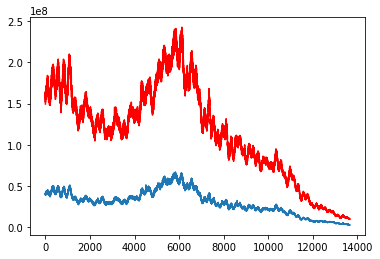

In [12]:
plot(result['xxoff'][0,:])
plot(result['xxon'][0,:], 'r')

In [13]:
gainr = result['xxon'] - result['xxoff']
print gainr.shape

(1431, 13662)


In [14]:
df = 16384 / 1500.
print df

10.9226666667


In [112]:
print 150 * df
print 1400 * df

1638.4
15291.7333333


In [113]:
i0 = 1639
i1 = 15291

In [114]:
print (i1 - i0) / df

1249.87792969


In [139]:
freqs = np.arange(16384) / df

In [140]:
freqs

array([  0.00000000e+00,   9.15527344e-02,   1.83105469e-01, ...,
         1.49972534e+03,   1.49981689e+03,   1.49990845e+03])

In [143]:
hdu.data['CRVAL1']

array([  4.57500000e+09,   4.57500000e+09,   4.57500000e+09, ...,
         4.57500000e+09,   4.57500000e+09,   4.57500000e+09])

In [144]:
hdu.data['CDELT1']

array([-91552.734375, -91552.734375, -91552.734375, ..., -91552.734375,
       -91552.734375, -91552.734375])

In [145]:
hdu.data['CRPIX1']

array([ 8193.,  8193.,  8193., ...,  8193.,  8193.,  8193.])

In [146]:
indxes = np.arange(16384) + 1
freq = 4.575e9 - 91552.734375 * (indxes - 8193)

In [147]:
freq

array([  5.32500000e+09,   5.32490845e+09,   5.32481689e+09, ...,
         3.82527466e+09,   3.82518311e+09,   3.82509155e+09])

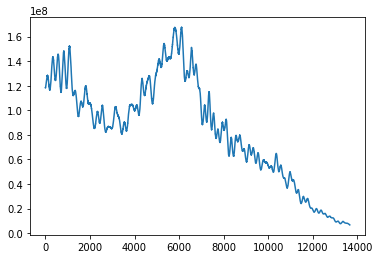

In [115]:
plot(np.nanmean(gainr, 0))

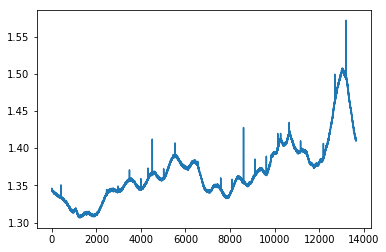

In [116]:
plot(np.nanmedian(result['xxon'], 0) / np.nanmedian(gainr, 0))

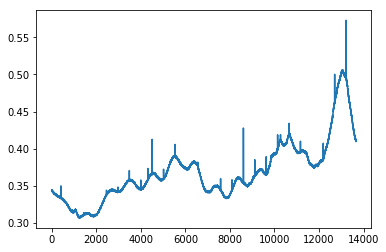

In [117]:
plot(np.nanmedian(result['xxoff'], 0) / np.nanmedian(gainr, 0))

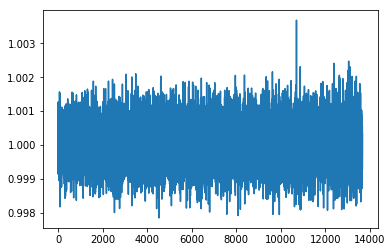

In [118]:
plot(np.nanmedian(result['xxon'], 0) / np.nanmedian(gainr, 0) - np.nanmedian(result['xxoff'], 0) / np.nanmedian(gainr, 0))

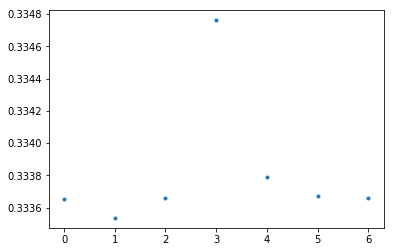

In [119]:
plot(np.nanmedian(result['xxoff'][:,405:412], 0) / np.nanmedian(gainr[:,405:412], 0), '.')

In [120]:
print np.nanmedian(result['xxoff'][:,409], 0) / np.nanmedian(gainr[:,409], 0)

0.333788


In [121]:
print np.nanmedian(result['xxoff'][:,408], 0) / np.nanmedian(gainr[:,408], 0)

0.334761


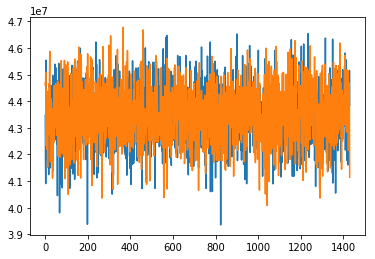

In [122]:
plot(result['xxoff'][:,409])
plot(result['xxoff'][:,408])

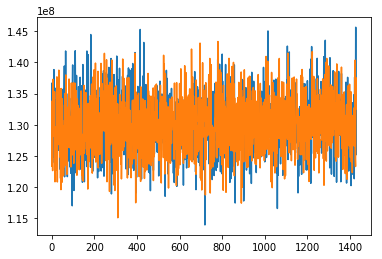

In [123]:
plot(gainr[:,409])
plot(gainr[:,408])

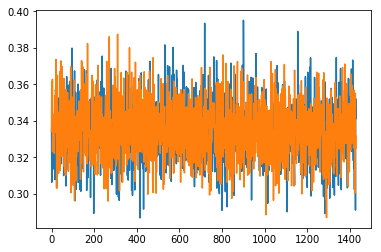

In [124]:
plot(result['xxoff'][:,409] / gainr[:,409])
plot(result['xxoff'][:,408] / gainr[:,408])

# Let's start with persistent RFI mitigation.  Ie we average the spectra in time and if a bin has RFI then we kill that bin.  Can look later at RFI that is short in time. 

In [16]:
def mad(x, axis=None):
    return np.nanmedian(np.abs(x - np.nanmedian(x, axis)), axis)

In [17]:
def moving_median(x, N):
    idx = np.arange(N) + np.arange(len(x) - N + 1)[:, None]
    return np.nanmedian(x[idx], axis=1)

In [18]:
def moving_mean(x, N):
    idx = np.arange(N) + np.arange(len(x) - N + 1)[:, None]
    return np.nanmean(x[idx], axis=1)

In [19]:
spec = np.nanmedian(result['xxoff'], 0) / np.nanmedian(gainr, 0)

In [20]:
mvmedspec = moving_median(spec, 5)
mvmeanspec = moving_mean(spec, 5)

In [21]:
print spec.shape

(13662,)


In [22]:
print mvmedspec.shape
print mvmeanspec.shape

(13658,)
(13658,)


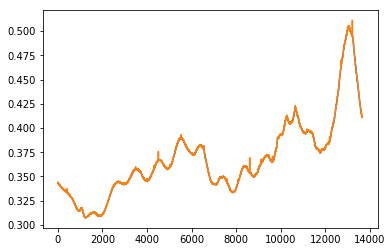

In [23]:
plot(mvmedspec)
plot(mvmeanspec)

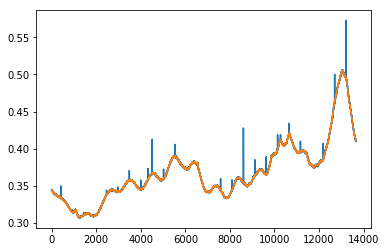

In [24]:
plot(spec)
plot(mvmedspec)

In [25]:
len(spec[:-4])

13658

In [26]:
madspec = mad(spec[:-4] - mvmedspec)

In [27]:
stdspec = np.std(spec[:-4] - mvmedspec)

In [28]:
print madspec
print stdspec

0.000273958
0.00129974


In [33]:
1.4826 * 5

7.412999999999999

In [32]:
madspec * 1.4826 

0.00040616990625858305

In [29]:
stdspec / madspec / 1.4826

3.1999793593641979

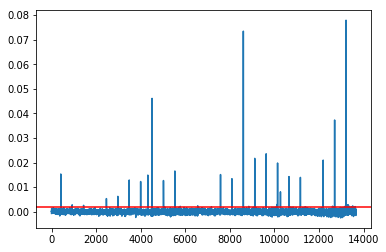

In [34]:
plot(spec[:-4] - mvmedspec)
#axhline(madspec, color='r')
axhline(7.4 * madspec, color='r')
#axhline(stdspec, color='purple')
#axhline(stdspec, color='purple')

In [36]:
result.keys()

['yyon', 'yyoff', 'yxon', 'yxoff', 'xxoff', 'xyoff', 'xxon', 'xyon']

In [37]:
result['xxoff'].shape

(1431, 13662)

In [38]:
xxdata = result['xxoff']

In [47]:
x = spec[:-4] - mvmedspec
mask = x < 10 * madspec

In [48]:
mask.shape

(13658,)

In [49]:
2**14 / 32 

512

In [50]:
np.flatnonzero(~mask)

array([  414,   926,  2462,  2974,  3486,  3998,  4320,  4510,  5022,
        5534,  7582,  8094,  8606,  9118,  9630, 10123, 10142, 10271,
       10654, 11166, 12190, 12702, 13214, 13301])

In [51]:
np.diff(np.flatnonzero(~mask))

array([ 512, 1536,  512,  512,  512,  322,  190,  512,  512, 2048,  512,
        512,  512,  512,  493,   19,  129,  383,  512, 1024,  512,  512,
         87])

In [184]:
x = spec[:-4] - mvmedspec
mask = x < 18 * madspec
mask &= x != 0.0

In [39]:
import seaborn as sns

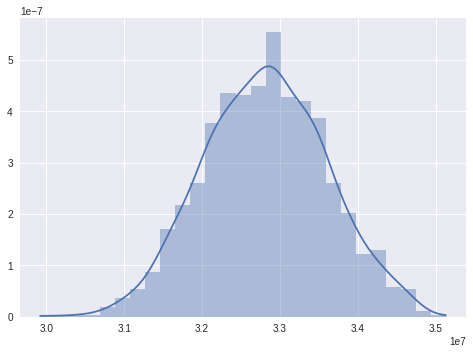

In [40]:
sns.distplot(xxdata[:,2000])

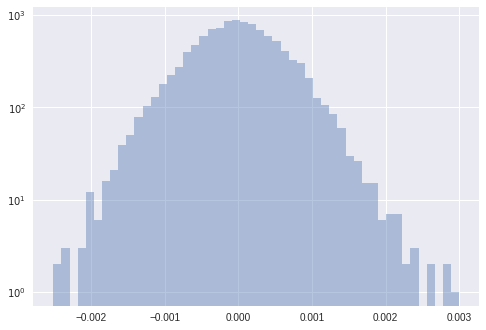

In [185]:
sns.distplot(x[mask], kde=False)
yscale('log')

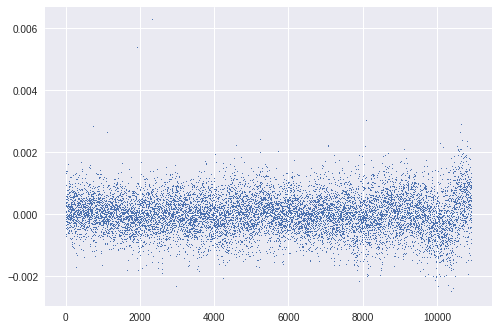

In [176]:
plot(x[mask], ',')

In [189]:
mask = (spec[:-4] - mvmedspec) > (18 * madspec)

In [190]:
newspec = spec[:-4] + 0.

In [191]:
newspec[mask] = np.nan

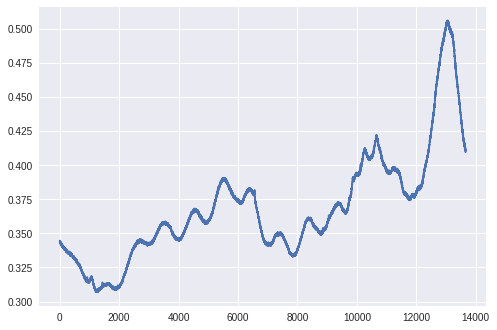

In [192]:
plot(newspec)